In [1]:
import numpy as np
import pandas as pd
import re
import torch
from torch import nn
import torch.nn.functional as F
import os
import sklearn
import json
from tqdm.notebook import tqdm
import Levenshtein
import glob

In [1]:
# share embedding for input and output

# ordinal encoding

In [2]:
path_to_data_folder = "../data"

In [3]:
with open(path_to_data_folder + "/character_to_prediction_index.json") as json_file:
    CHAR2ORD = json.load(json_file)
    
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


# hyperparameters

In [4]:
#IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
SEED = 42
DEBUG = True
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1 + 1#
PAD_TOKEN = len(CHAR2ORD) # Padding
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence
NAN_TOKEN = len(CHAR2ORD) + 3
BATCH_SIZE = 64
NUM_EPOCHS = 20 #if IS_INTERACTIVE else 100
NUM_WARMUP_EPOCHS = 10
WEIGHT_DECAY = 0.05
NUM_WORKERS = 2
TRAIN_MODEL = True
LOAD_WEIGHTS = False
MAX_LR = 1e-3
WARMUP_METHOD = 'exp'
USE_VAL = True
N_TARGET_FRAMES = 128
N_COLS = 164
MAX_PHRASE_LENGTH = 32

In [5]:
torch.manual_seed(SEED)

# data manipulation

In [6]:
ORD2CHAR[PAD_TOKEN] = "<PAD>"
ORD2CHAR[SOS_TOKEN] = "<SOS>"
ORD2CHAR[EOS_TOKEN] = "<EOS>"
ORD2CHAR[NAN_TOKEN] = "<NAN>"
CHAR2ORD["<PAD>"] = PAD_TOKEN
CHAR2ORD["<SOS>"] = SOS_TOKEN
CHAR2ORD["<EOS>"] = EOS_TOKEN
CHAR2ORD["<NAN>"] = NAN_TOKEN

In [18]:
# # Read Train DataFrame
# if DEBUG:
#     train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
# else:
#     train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# # Set Train Indexed By sqeuence_id
# train_sequence_id = train.set_index('sequence_id')

# # Number Of Train Samples
# N_SAMPLES = len(train)
# print(f'N_SAMPLES: {N_SAMPLES}')

# display(train.info())
# display(train.head())


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/asl-fingerspelling/train.csv'

In [14]:
# def get_file_path(path):
#     return f'/kaggle/input/asl-fingerspelling/{path}'

# train['file_path'] = train['path'].apply(get_file_path)


In [15]:
# INFERENCE_FILE_PATHS = pd.Series(
#         glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
#     )

# print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


# Load data

In [38]:
if USE_VAL:
    # TRAIN
    X_train = np.load(path_to_data_folder + '/X_train.npy')
    y_train = np.load(path_to_data_folder + '/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load(path_to_data_folder + '/X_val.npy')
    y_val = np.load(path_to_data_folder + '/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# Train On All Data
else:
    # TRAIN
    X_train = np.load(path_to_data_folder + '/X.npy')
    y_train = np.load(path_to_data_folder + '/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')

X_train shape: (54719, 128, 164), X_val shape: (7236, 128, 164)


In [39]:
mean = np.load(path_to_data_folder + "/MEANS.npy")
std = np.load(path_to_data_folder + "/STDS.npy")
mean.shape, std.shape

((164,), (164,))

In [40]:
for i in range(len(X_train)):
    X_train[i] = (X_train[i] - mean) / std

In [41]:
if USE_VAL:
    for i in range(len(X_val)):
        X_val[i] = (X_val[i] - mean) / std

in X i've right hand, left hand, lips coords(x,y) for i in range(number of frames)

and in y i have char for X hands and lips position

the main problem is that there are 128 frames and only 31 letters, so i gotta combine some frames that represent the same letter

In [42]:
y_train.shape

(54719, 32)

In [21]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())



# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


In [22]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [23]:
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [25]:
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [26]:
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

# Baseline

In [7]:
mean = torch.from_numpy(mean)
std = torch.from_numpy(std)

NameError: name 'mean' is not defined

In [ ]:
kernel_size = 2
stride = 2

In [8]:
class SignRecognition(nn.Module):
    def __init__(self, frames, kernel_size=2, stride=2):
        super().__init__()
        self.conv1 = nn.Conv2d(frames, frames // 4, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm2d(frames // 4)
        self.lin1 = nn.Linear(41, 128)
        self.lin2 = nn.Linear(128, N_UNIQUE_CHARACTERS)
        self.gelu = torch.nn.GELU()
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, x):
        x = self.conv1(x) # 128 41 1
        x = self.gelu(self.bn1(x))
        x = x.squeeze(dim=-1)
        x = self.lin1(x)
        x = self.gelu(x)
        x = self.lin2(x)
        x = self.softmax(x)
        return x

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size) # concat them
        
    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        
        # split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)
        
        # energy shape: (N, heads, query_len, key_len) table with attention on
        # each word from target to input
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
            
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        # since value_len == key_len i use l for both
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads*self.head_dim,
        ) # flatten last 2 dimensions
        
        out = self.fc_out(out)
        return out
        

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super().__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out
    
class Encoder(nn.Module):
    def __init__(
            self,
            scr_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
    ):
        super().__init__()
        self.embed_size = embed_size
        self.device = device
       # self.word_embedding = nn.Embedding(scr_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, dropout, forward_expansion)
                for _ in range(num_layers)
            ]
        )    
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        N, seq_length, vocab = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(device)
        
        out = self.dropout(x + self.position_embedding(positions))
        # x B, Seq_len, vocab_size
        # pos B, Seq_len, n_embd
        for layer in self.layers:
            # since we are in encoder and values, queries and keys are the same
            out = layer(out, out, out, mask)
            
        return out
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super().__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)
        
    # valule and key are from encoder
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out
    
class Decoder(nn.Module):
    def __init__(
            self,
            trg_vocab_size,
            embed_size, 
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
    ):
        super().__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x) 
        return out
        
        
class Transformer(nn.Module):
    def __init__(
            self,
            scr_vocab_size,
            trg_vocab_size,
            src_pad_idx,
            trg_pad_idx,
            embed_size=63,
            num_layers=6,
            forward_expansion=4,
            heads=9,
            dropout=0,
            device="cuda",
            max_length=128
    ):
        super().__init__()
        
        self.encoder = Encoder(
            scr_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )
        
        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
        )
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        # (N, 1, 1, src_length)
        # src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # return src_mask.to(self.device)
        return None
    
    def make_trg_mask(self, trg):
        N, trg_length = trg.shape
        trg_mask = torch.tril(torch.ones((trg_length, trg_length))).expand(
            N, 1, trg_length, trg_length
        )
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out
    

In [10]:
type(train)

NameError: name 'train' is not defined

In [11]:
isinstance(train, pd.core.frame.DataFrame)

NameError: name 'train' is not defined

In [12]:
class PreprocessLayer(nn.Module):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        
        self.normalisation_correction = torch.tensor(
            [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
            dtype=torch.float32,
        )
        
    def forward(self, data0, resize=True):
        # Fill NaN Values With 0
        if isinstance(data0, pd.core.frame.DataFrame):
            data0 = torch.tensor(data0.values)
        data = torch.where(torch.isnan(data0), torch.tensor(0.0), data0)
        
        data = data.unsqueeze(0)
        
        # Empty Hand Frame Filtering
        hands = data[:, :, :84]
        hands = torch.abs(hands)
        mask = torch.sum(hands, dim=2)
        mask = mask != 0
        data = data[mask]
        
        # Pad Zeros
        N_FRAMES = len(data)
        #print(data.shape)
        if N_FRAMES < N_TARGET_FRAMES:
            data = torch.cat((
                data.unsqueeze(0),
                torch.zeros(1, N_TARGET_FRAMES - N_FRAMES, N_COLS),
            ), dim=1)

        # Downsample
        if len(data.shape) == 2:
            data = data.unsqueeze(0)
        resized_data = F.interpolate(
            data.unsqueeze(0), 
            size=(N_TARGET_FRAMES, N_COLS), 
            mode='bilinear', 
            align_corners=False
        ).squeeze(0)
        
        resized_data[0] = (resized_data[0] - mean) / std
        return resized_data.view(len(resized_data), N_TARGET_FRAMES, N_COLS // 2, 2)


In [13]:
class Tokenizer:
    def __init__(self):
        pass
    def decode(self, out: torch.tensor) -> str:
        """
        decode output of model into text
        """
        text = []
        for x in out:
            token = x.item()
            if token == PAD_TOKEN:
                continue # what if pad token will be in the middle of sentence
            text.append(ORD2CHAR[token])
        return ''.join(text)
    
    def encode(self, string: str) -> torch.tensor:
        """
        encode string into vocab size space so that i can put it as my target while training
        """
        out = []
        for symbol in string:
            out.append(CHAR2ORD[symbol])
        
        return torch.tensor(out)        
tokenizer = Tokenizer()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
class Model(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device):
        super().__init__()
        self.cnn = SignRecognition(128).to(device)
        self.transformer = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device)
        self.preprocess_layer = PreprocessLayer()

    def forward(self, x, decoder_input_ids=None):
        self.train()
        if decoder_input_ids is not None:
            x = self.cnn(x) # [B, T, Vocab_size]
            x = self.transformer(x, decoder_input_ids)
        else:
            x = self.inference(x)
    
        return x
        
    def inference(self, x):
        self.eval()
        x = self.preprocess_layer(x).to(device)
#         if len(x.shape) == 3:
#             x = x.unsqueeze(0)
        #print(x.shape)
        trg = torch.full((x.shape[0], 1), SOS_TOKEN, dtype=torch.long).to(device)
        for _ in range(MAX_PHRASE_LENGTH):
            with torch.no_grad():
                out = self(x, trg)[:, -1, :]
            token = out.argmax(-1).unsqueeze(-1)
            trg = torch.cat((trg, token), -1)
            
            if (token == EOS_TOKEN).all():
                break
                
        return tokenizer.decode(trg[0])
        

In [37]:
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[19]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)
    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data

preprocess_layer = PreprocessLayer()

if IS_INTERACTIVE:
    data = test_preprocess_layer()

demo_raw_data shape: (122, 164)
data shape: torch.Size([1, 128, 82, 2])


In [38]:
demo_sequence_id = example_parquet_df.index.unique()[15]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
demo_raw_data

,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.536143,0.514210,0.519691,0.531983,0.523121,0.529981,0.516128,0.534680,0.520337,0.522814
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.535060,0.514881,0.519775,0.531294,0.522798,0.529248,0.516640,0.533826,0.520163,0.522484
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.534988,0.514349,0.519791,0.531961,0.522935,0.530020,0.516407,0.534115,0.520159,0.522496
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.532536,0.511367,0.516521,0.529202,0.519584,0.526958,0.513265,0.531592,0.516477,0.519001
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.529577,0.507558,0.513263,0.526232,0.516685,0.524348,0.509678,0.528519,0.513844,0.516380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.513958,0.493244,0.499994,0.512223,0.504217,0.511437,0.495716,0.513554,0.502403,0.504038
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514730,0.493438,0.500040,0.512429,0.504052,0.511178,0.495896,0.514143,0.502095,0.503897
1817282569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.514045,0.493771,0.499412,0.511476,0.503066,0.510184,0.495837,0.513310,0.501498,0.503101


In [16]:
src_pad_idx = PAD_TOKEN
trg_pad_idx = PAD_TOKEN
src_vocab_size = 63
trg_vocab_size = 63

In [17]:
model = Model(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
model

NameError: name 'LEFT_HAND_NAMES0' is not defined

# Preprocess targets

In [45]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
if USE_VAL:
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)

In [46]:
y_train[0:4]

tensor([[18,  0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36, 61, 59, 59, 59, 59, 59,
         59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59],
        [39, 36, 45, 51, 32, 40, 39, 52, 33, 50, 13, 34, 46, 44, 61, 59, 59, 59,
         59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59],
        [16, 18, 23, 18,  0, 54, 40, 43, 43, 40, 32, 44,  0, 43, 32, 45, 40, 36,
         49, 61, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59],
        [24, 23, 23,  0, 37, 49, 32, 45, 42, 43, 40, 45,  0, 43, 32, 45, 36, 61,
         59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]])

In [47]:
X_train[4:8, 20:30, :10]

tensor([[[-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
         [-6.4010, -5.8373, -5.1874, -4.6228, -3.9383, -5.5864, -4.9335,
          -4.4449, -4.0016, -5.9498],
 

In [48]:
num_examples, frames, features = X_train.shape
X_train = X_train.view(num_examples, frames, features // 2, 2)
X_train.shape

torch.Size([54719, 128, 82, 2])

In [49]:
if USE_VAL:
    num_examples, frames, features = X_val.shape
    X_val = X_val.view(num_examples, frames, features // 2, 2)
    X_val.shape

In [50]:
y_train = y_train.type(torch.LongTensor)
if USE_VAL:
    y_val = y_val.type(torch.LongTensor)

In [51]:
decoder_input_ids_train = torch.zeros_like(y_train)
decoder_input_ids_train.shape

torch.Size([54719, 32])

In [52]:
for i in range(len(y_train)):
    decoder_input_ids_train[i] = torch.concat((torch.tensor([SOS_TOKEN]), y_train[i][:-1]))

In [53]:
if USE_VAL:
    decoder_input_ids_val = torch.zeros_like(y_val)
    decoder_input_ids_val.shape

In [54]:
if USE_VAL:
    for i in range(len(y_val)):
        decoder_input_ids_val[i] = torch.concat((torch.tensor([SOS_TOKEN]), y_val[i][:-1]))

In [55]:
decoder_input_ids_train = decoder_input_ids_train.type(torch.LongTensor)
if USE_VAL:
    decoder_input_ids_val = decoder_input_ids_val.type(torch.LongTensor)

# Creating Dataloader

In [43]:
from torch.utils.data import DataLoader


In [44]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, decoder_input_ids):
        self.data = data
        self.labels = labels
        self.decoder_input_ids = decoder_input_ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        decoder_input_ids = self.decoder_input_ids[index]
        return x, y, decoder_input_ids


In [45]:
train_dataset = CustomDataset(X_train, y_train, decoder_input_ids_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

In [46]:
if USE_VAL:
    val_dataset = CustomDataset(X_val, y_val, decoder_input_ids_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

# Levenshtein distance

In [47]:
import time

In [48]:
def encode_target(target: torch.tensor):
    answer = []
    for x in target:
        if x != PAD_TOKEN:
            answer.append(ORD2CHAR[x.item()])
    return "".join(answer)


In [49]:
def metric(pred: torch.tensor, target:torch.tensor):
    # shouldn't count pad token 
    # if i would use it in model
    # since levenshtein distance is not linear i'll return N and D of each batch and then sum them
    D = 0
    N = 0
    for i in range(len(pred)):# through batches
        p = encode(pred[i])
        t = encode_target(target[i])
        distance = Levenshtein.distance(p, t)
        
        D += distance
        N += len(p) + len(t)
    
    return N, D


In [50]:
# # testing metric
# for idx, (x, y) in enumerate(train_dataloader):
#     out = model(x)
#     print(metric(out, y))
#     if idx > 5:
#         break

# train parameters(optimizer, loss, etc)

In [90]:
model = nn.Sequential(
    nn.Linear(100, 1)
)

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-6
)

/home/qklent/programming/machine_learning/alfa_bank_receipts/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train loop

In [52]:
# for g in optimizer.param_groups:
#     g['lr'] = 1e-3

overfitting on single example

In [58]:
x = X_train[0].unsqueeze(0).to(device)
y = y_train[0].unsqueeze(0).to(device)
ids = decoder_input_ids_train[0].unsqueeze(0).to(device)
x.shape, y.shape, ids.shape

(torch.Size([1, 128, 82, 2]), torch.Size([1, 32]), torch.Size([1, 32]))

In [59]:
for i in range(10000):
    out = model(x, ids)
    optimizer.zero_grad()
    loss = l
    loss = loss_fn(out.view(-1, N_UNIQUE_CHARACTERS), y.view(-1))
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"n = {i}, loss = {loss.item()}")
        

NameError: name 'model' is not defined

In [83]:
def lrfn(curr_epoch, num_cycles=0.50):
    
    if curr_epoch < NUM_WARMUP_EPOCHS:
        if WARMUP_METHOD == 'log':
            return MAX_LR * 0.10 ** (NUM_WARMUP_EPOCHS - curr_epoch)
        else:
            return MAX_LR * 2 ** -(NUM_WARMUP_EPOCHS - curr_epoch)
    else:
        progress = float(curr_epoch - NUM_WARMUP_EPOCHS) / float(max(1, NUM_EPOCHS - NUM_WARMUP_EPOCHS))

        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * float(num_cycles) * 2.0 * progress))) * MAX_LR

In [84]:
lrs = []
for epoch in range(NUM_EPOCHS):
    lrs.append(lrfn(epoch))

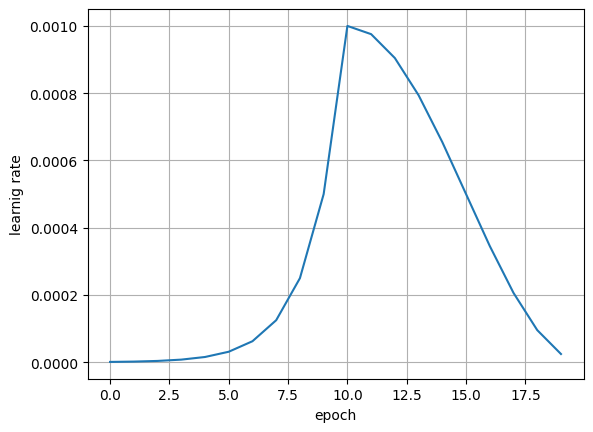

In [86]:
import matplotlib.pyplot as plt
plt.plot(lrs)
plt.xlabel("epoch")
plt.ylabel("learnig rate")
plt.grid()

In [94]:
def set_learning_rate(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
    

In [99]:
set_learning_rate(optimizer, 1e-4)

In [100]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

In [60]:
# loop with lr scheduler
for epoch in tqdm(range(N_EPOCHS)):
    lr = lrfn(epoch)
    set_learning_rate(optimizer, lr)
    for idx, (x, y, decoder_input_ids) in enumerate(tqdm(train_dataloader, leave=False)):
        x = x.to(device)
        y = y.to(device)
        decoder_input_ids = decoder_input_ids.to(device)

        

In [93]:
optimizer.set_learning_rate()

AttributeError: 'AdamW' object has no attribute 'set_learning_rate'

real training starts

In [53]:
epoch_losses = []
for epoch in tqdm(range(NUM_EPOCHS * 2)):
    total_loss = 0
    # loop = tqdm(train_dataloader, leave=False)
    #train_NDs = [] # array with pairs (N, D) 
    for (x, y, decoder_input_ids) in tqdm(train_dataloader, leave=False):
        x = x.to(device)
        y = y.to(device)
        decoder_input_ids = decoder_input_ids.to(device)

        out = model(x, decoder_input_ids)
        #print(out.shape)        
        optimizer.zero_grad()
        loss = loss_fn(out.view(-1, N_UNIQUE_CHARACTERS), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # if epoch % 5 == 0:
        #     train_NDs.append(metric(out, y))
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS * 2}] Average Loss: {avg_loss}")
    epoch_losses.append(avg_loss)
        


        # validation score 
    # CHANGE NAME FOR LOOP!!!!!!!!!!!!!!!!!!!!!
        # loop = tqdm(val_dataloader, leave=False)
        # for (x, y) in loop:
        #     x = x.to(device)
        #     y = y.to(device)
        #     with torch.no_grad():
        #         out = model(x)
        #     loss = loss_fn(out.view(BATCH_SIZE, -1, 31), y)
        #     val_losses.append(loss.item())
        
        # print(f"Validation loss on epoch №{epoch + 1} = {sum(val_losses) / len(val_losses)}\nbtw train loss = {mean_loss}")
        
        
    #val_losses = []
    # if epoch % 5 == 0:
    #     # compute levenshtein distance on validation data
    #     loop = tqdm(val_dataloader, leave=False)
    #     val_NDs = []
    #     for (x,y) in loop:
    #         x = x.to(device)
    #         y = y.to(device)
    #         with torch.no_grad():
    #             out = model(x)
    #         val_NDs.append(metric(out, y))
            
    #     train_distance = 1 - sum(x[1] for x in train_NDs) / sum(x[0] for x in train_NDs)
    #     val_distance = 1 - sum(x[1] for x in val_NDs) / sum(x[0] for x in val_NDs)
        
        
        
    #     print(f"epoch№ {epoch + 1}\ntrain_distance = {train_distance}\nval_distance = {val_distance}\n\n")
            
        


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [1/40] Average Loss: 3.6485833376297068


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [2/40] Average Loss: 2.979034242641172


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [3/40] Average Loss: 2.8001710299306506


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [4/40] Average Loss: 2.684578960059119


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [5/40] Average Loss: 2.592265480854472


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [6/40] Average Loss: 2.5163696261702992


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [7/40] Average Loss: 2.452917773215497


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [8/40] Average Loss: 2.3983193362345463


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [9/40] Average Loss: 2.350876331887703


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [10/40] Average Loss: 2.308725780848876


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [11/40] Average Loss: 2.2698094554472306


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [12/40] Average Loss: 2.232404386131769


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [13/40] Average Loss: 2.1948934313284987


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [14/40] Average Loss: 2.1578163003474824


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [15/40] Average Loss: 2.1223648807483197


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [16/40] Average Loss: 2.089654674993466


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [17/40] Average Loss: 2.0597638889833134


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [18/40] Average Loss: 2.0325539011586744


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [19/40] Average Loss: 2.0079489055785418


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [20/40] Average Loss: 1.9850425051581944


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [21/40] Average Loss: 1.9640883184986875


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [22/40] Average Loss: 1.9445345270549943


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [23/40] Average Loss: 1.9261500120721322


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [24/40] Average Loss: 1.9091417295312993


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [25/40] Average Loss: 1.8925882039081297


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [26/40] Average Loss: 1.8771341133173511


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [27/40] Average Loss: 1.8624904426534505


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [28/40] Average Loss: 1.8487874689649364


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [29/40] Average Loss: 1.83545682329763


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [30/40] Average Loss: 1.8230387518221656


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [31/40] Average Loss: 1.8111366919946335


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [32/40] Average Loss: 1.799624590460534


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [33/40] Average Loss: 1.7889782085630876


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [34/40] Average Loss: 1.7786412230699347


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [35/40] Average Loss: 1.7686405017169353


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [36/40] Average Loss: 1.7593151395158968


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [37/40] Average Loss: 1.7501832477102794


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [38/40] Average Loss: 1.7415163632857436


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [39/40] Average Loss: 1.7332004229134643


  0%|          | 0/854 [00:00<?, ?it/s]

Epoch [40/40] Average Loss: 1.725244686251781


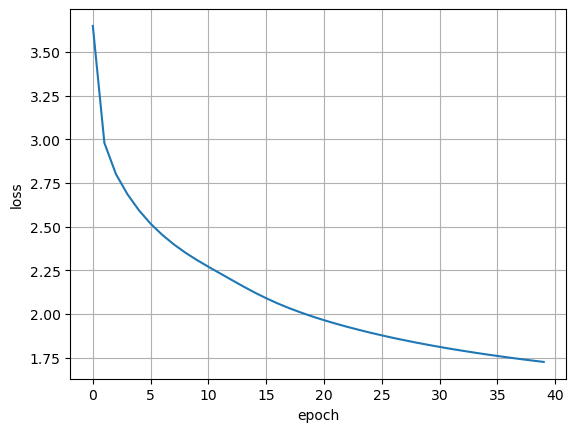

In [54]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

In [34]:
PATH = "/kaggle/working/checkpoint.pth.tar"

In [72]:
torch.save(model.state_dict(), PATH)

# inference

In [35]:
model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/checkpoint.pth.tar'

In [41]:
demo_sequence_id = example_parquet_df.index.unique()[9]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]

In [42]:
out = model(demo_raw_data)
out

'<SOS>8__mz(,1 (,1q[l:f m:$b?n umz:(_m'

In [38]:
out

'<SOS>8__mz(,1 (,1q[l:f m:$b?n umz:(_m'

In [6]:
!pip install onnx_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 7.8 MB/s eta 0:00:00


In [7]:
!pip install --upgrade tensorflow tensorflow-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:0000:0100:01
ERROR: Could not find a version that satisfies the requirement tensorflow-lite (from versions: none)
ERROR: No matching distribution found for tensorflow-lite


In [8]:
import onnx
import tensorflow as tf
import onnx_tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [41]:
def convert_to_tflite(nodel, name, path_to_models="../models"):
    demo_sequence_id = example_parquet_df.index.unique()[19]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    onnx_model_path = f"{path_to_models}/{name}.onnx"
    tf_model_path = "tf_model"
    tflite_model_path = f"{path_to_models}/{name}.tflite"
    opset_version = 12 # ? i don't know if it's a right value
    torch.onnx.export(
        model,                       # PyTorch Model
        torch.from_numpy(demo_raw_data.values),                # Input tensor
        onnx_model_path,             # Output file (eg. 'output_model.onnx')
        opset_version=opset_version, # Operator support version
    )
    
    print("converting from onnx to tensorflow...")
    onnx_model = onnx.load(onnx_model_path)
    tf_model = onnx_tf.backend.prepare(onnx_model)
    tf_model.export_graph(tf_model_path)

    print("converting from tensorflow to tflite")
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
    tflite_model = converter.convert()
    # Save the model
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print("converting finish!!")

In [42]:
convert_to_tflite(model, "my_transformer", path_to_models="/kaggle/working")

/tmp/ipykernel_28/2885654078.py:14: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  data = torch.where(torch.isnan(data0), torch.tensor(0.0), data0)
/tmp/ipykernel_28/2885654078.py:26: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  N_FRAMES = len(data)
/tmp/ipykernel_28/2885654078.py:45: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  return resized_data.view(len(resized_data), N_TARGET_FR

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [120]:
import gc

In [51]:
!zip -r tf_model.zip tf_model/

  adding: tf_model/ (stored 0%)
  adding: tf_model/variables/ (stored 0%)
  adding: tf_model/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: tf_model/variables/variables.index (deflated 33%)
  adding: tf_model/assets/ (stored 0%)
  adding: tf_model/fingerprint.pb (stored 0%)
  adding: tf_model/saved_model.pb (deflated 71%)


In [48]:
!ls

my_transformer.onnx  tf_model


In [28]:
cnn = SignRecognition(128)
transformer = Transformer(63, 63, PAD_TOKEN, PAD_TOKEN, device="cpu")

In [29]:
data1 = torch.randn(1, 128, 82, 2)
data2 = torch.randn(1, 128, 82, 2)


In [34]:
transformer(cnn(data1), torch.randint(0, 63, size=[1, 29])).argmax(dim=-1)

tensor([[20,  6, 39, 59,  6, 57, 36,  9, 60, 40, 39,  9, 39, 59, 40, 11, 41, 62,
         11, 11,  6, 36, 30, 20, 43, 62, 15,  9, 60]])

In [35]:
transformer(cnn(data2), torch.randint(0, 63, size=[1, 29])).argmax(dim=-1)

tensor([[52, 36, 38, 11,  4, 11, 33,  9, 26,  9, 39,  9, 15,  9,  9,  9, 36, 31,
         62,  6, 57, 60, 30,  9, 54, 11, 11, 57, 62]])

In [36]:
cnn

SignRecognition(
  (conv1): Conv2d(128, 32, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=41, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=63, bias=True)
  (gelu): GELU(approximate='none')
  (softmax): Softmax(dim=-1)
)